In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Prepare Data

In [3]:
cloud_cover = pd.read_csv('../succeed-prophet/Bangkhuntean_CloudCover_2021-16Nov-16Dec.csv',skipinitialspace = True)
cloud_cover['Date'] = cloud_cover[['Year', 'Month', 'Day']].apply(lambda x: "{0}-{1}-{2}".format(str(x[0]).zfill(2), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1) 
cloud_cover['Time'] = cloud_cover[['Hour', 'Minute']].apply(lambda x: "{}:{}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
cloud_cover.drop(["Year", "Month", "Day", "Hour", "Minute", "Second"], axis=1, inplace=True)  
cloud_cover = cloud_cover.rename(columns={"CloudCover":"cloud_cover"})
cloud_cover = cloud_cover.groupby(['Date', 'Time']).agg(cloud_cover=('cloud_cover','mean')).reset_index()
cloud_cover['DateTime'] = cloud_cover[['Date', 'Time']].apply(lambda x: "{} {}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
cloud_cover.drop(["Date", "Time"], axis=1, inplace=True)        
cloud_cover['DateTime'] = pd.to_datetime(cloud_cover['DateTime'], format="%Y-%m-%d %H:%M")
cloud_cover.dropna(inplace=True)
cloud_cover


,cloud_cover,DateTime
0,0.990000,2021-11-16 11:15:00
1,0.989000,2021-11-16 11:16:00
2,0.987667,2021-11-16 11:17:00
3,0.987000,2021-11-16 11:18:00
4,0.987000,2021-11-16 11:19:00
...,...,...
15056,0.168000,2021-12-16 13:58:00
15057,0.169000,2021-12-16 13:59:00
15058,0.147000,2021-12-16 14:00:00
15059,0.145000,2021-12-16 14:01:00


# Train/Test Model

In [4]:
train,test = train_test_split(cloud_cover, train_size=0.8, shuffle=False)
print('Train Shape', train.shape)
print('Test Shape', test.shape)

Train Shape (12048, 2)
Test Shape (3013, 2)


In [5]:
train = train.set_index('DateTime')
test = test.set_index('DateTime')

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train)

X_train = []
y_train = []
for i in range(30, 12048):
    X_train.append(training_set_scaled[i-30:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [6]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [7]:
dataset_total = pd.concat((train['cloud_cover'],test['cloud_cover']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 30:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(30, 3043):
    X_test.append(inputs[i-30:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [8]:
print(X_test.shape)

(3013, 30, 1)


## Add first layer: units = 50

In [57]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1], 1)))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [58]:
regressor.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
376/376 [==============================] - 6s 10ms/step - loss: 0.0097
Epoch 2/30
376/376 [==============================] - 4s 10ms/step - loss: 0.0024
Epoch 3/30
376/376 [==============================] - 4s 10ms/step - loss: 0.0019
Epoch 4/30
376/376 [==============================] - 4s 10ms/step - loss: 0.0016
Epoch 5/30
376/376 [==============================] - 4s 10ms/step - loss: 0.0013
Epoch 6/30
376/376 [==============================] - 4s 10ms/step - loss: 0.0012
Epoch 7/30
376/376 [==============================] - 4s 10ms/step - loss: 0.0011
Epoch 8/30
376/376 [==============================] - 4s 10ms/step - loss: 0.0011
Epoch 9/30
376/376 [==============================] - 4s 10ms/step - loss: 0.0010
Epoch 10/30
376/376 [==============================] - 4s 10ms/step - loss: 9.8217e-04
Epoch 11/30
376/376 [==============================] - 4s 11ms/step - loss: 9.6920e-04
Epoch 12/30
376/376 [==============================] - 4s 10ms/step - loss: 9.6396e-04
E

In [59]:
predict_scaled = regressor.predict(X_test)
predict_scaled

95/95 [==============================] - 1s 4ms/step


array([[0.5489953 ],
       [0.5316355 ],
       [0.58522004],
       ...,
       [0.16314533],
       [0.14125761],
       [0.14019029]], dtype=float32)

In [60]:
predict = sc.inverse_transform(predict_scaled)
predict

array([[0.5501228 ],
       [0.5328064 ],
       [0.586257  ],
       ...,
       [0.16523747],
       [0.14340447],
       [0.14233981]], dtype=float32)

In [61]:
test['LSTM'] = predict
test

,cloud_cover,LSTM
DateTime,,
2021-12-10 15:24:00,0.538,0.550123
2021-12-10 15:25:00,0.588,0.532806
2021-12-10 15:26:00,0.566,0.586257
2021-12-10 15:27:00,0.562,0.555921
2021-12-10 15:28:00,0.612,0.555104
...,...,...
2021-12-16 13:58:00,0.168,0.164177
2021-12-16 13:59:00,0.169,0.164265
2021-12-16 14:00:00,0.147,0.165237


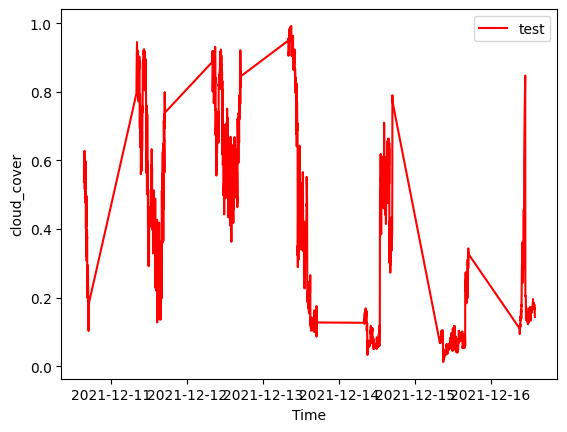

In [62]:
plt.plot(test['cloud_cover'], color = 'red', label = 'test')
plt.xlabel('Time')
plt.ylabel('cloud_cover')
plt.legend()
plt.show()

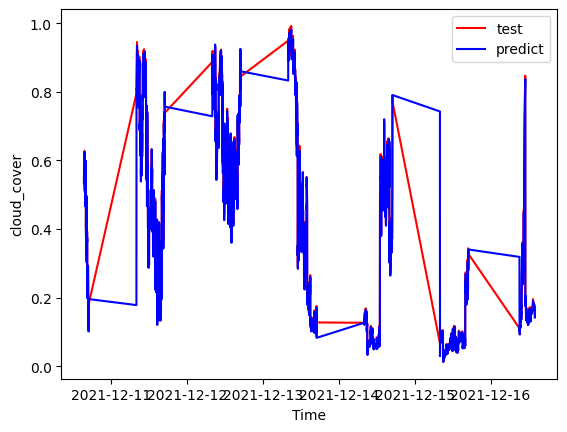

In [63]:
plt.plot(test['cloud_cover'], color = 'red', label = 'test')
plt.plot(test['LSTM'], color = 'blue', label = 'predict')
plt.xlabel('Time')
plt.ylabel('cloud_cover')
plt.legend()
plt.show()

In [64]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [65]:
lstm_mse_error = mean_squared_error(test['cloud_cover'], test['LSTM'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM'])
print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )

MSE Error: 0.002039072472871765
RMSE Error: 0.04515609009725892
MAE: 0.021456673273296794
r2_score: 0.9753330770015536


---

## Add frist layer: units = 100

In [66]:
regressor_1 = Sequential()
regressor_1.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train.shape[1], 1)))
regressor_1.add(Dense(units = 1))
regressor_1.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [67]:
regressor_1.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
376/376 [==============================] - 9s 18ms/step - loss: 0.0098
Epoch 2/30
376/376 [==============================] - 6s 17ms/step - loss: 0.0026
Epoch 3/30
376/376 [==============================] - 6s 17ms/step - loss: 0.0020
Epoch 4/30
376/376 [==============================] - 6s 17ms/step - loss: 0.0017
Epoch 5/30
376/376 [==============================] - 7s 17ms/step - loss: 0.0015
Epoch 6/30
376/376 [==============================] - 6s 17ms/step - loss: 0.0013
Epoch 7/30
376/376 [==============================] - 7s 18ms/step - loss: 0.0012
Epoch 8/30
376/376 [==============================] - 7s 18ms/step - loss: 0.0011
Epoch 9/30
376/376 [==============================] - 7s 18ms/step - loss: 0.0010
Epoch 10/30
376/376 [==============================] - 6s 17ms/step - loss: 0.0010
Epoch 11/30
376/376 [==============================] - 7s 18ms/step - loss: 0.0010
Epoch 12/30
376/376 [==============================] - 7s 18ms/step - loss: 9.7669e-04
Epoch 13/

In [68]:
predict_scaled_1 = regressor_1.predict(X_test)
predict_scaled_1

95/95 [==============================] - 1s 6ms/step


array([[0.5545891 ],
       [0.53663784],
       [0.5899076 ],
       ...,
       [0.16604768],
       [0.14441785],
       [0.1427689 ]], dtype=float32)

In [69]:
predict_1 = sc.inverse_transform(predict_scaled_1)
predict_1

array([[0.5557026 ],
       [0.53779626],
       [0.5909328 ],
       ...,
       [0.16813256],
       [0.14655681],
       [0.14491199]], dtype=float32)

In [70]:
test['LSTM_1'] = predict_1
test

,cloud_cover,LSTM,LSTM_1
DateTime,,,
2021-12-10 15:24:00,0.538,0.550123,0.555703
2021-12-10 15:25:00,0.588,0.532806,0.537796
2021-12-10 15:26:00,0.566,0.586257,0.590933
2021-12-10 15:27:00,0.562,0.555921,0.563057
2021-12-10 15:28:00,0.612,0.555104,0.561802
...,...,...,...
2021-12-16 13:58:00,0.168,0.164177,0.167105
2021-12-16 13:59:00,0.169,0.164265,0.167161
2021-12-16 14:00:00,0.147,0.165237,0.168133


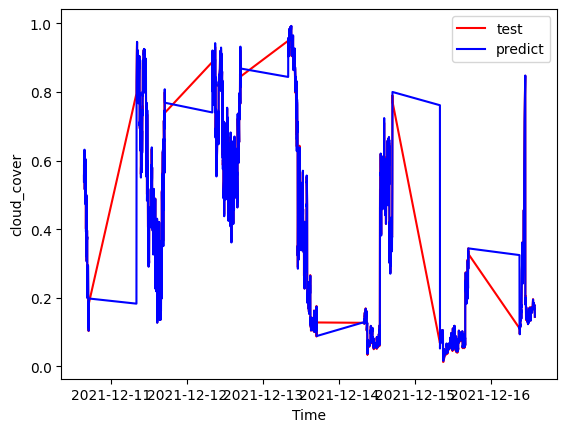

In [71]:
plt.plot(test['cloud_cover'], color = 'red', label = 'test')
plt.plot(test['LSTM_1'], color = 'blue', label = 'predict')
plt.xlabel('Time')
plt.ylabel('cloud_cover')
plt.legend()
plt.show()

In [72]:
lstm_mse_error = mean_squared_error(test['cloud_cover'], test['LSTM_1'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM_1'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM_1'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM_1'])
print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )

MSE Error: 0.002020609551262122
RMSE Error: 0.044951190765786415
MAE: 0.020055451975791033
r2_score: 0.9755564253482801


------------

## Add frist layer: unit = 100 and Add Dropout = 0.1

In [75]:
regressor_2 = Sequential()
regressor_2.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1], 1)))
regressor_2.add(Dropout(0.1))
regressor_2.add(Dense(units = 1))
regressor_2.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [76]:
regressor_2.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
376/376 [==============================] - 8s 12ms/step - loss: 0.0116
Epoch 2/30
376/376 [==============================] - 5s 14ms/step - loss: 0.0035
Epoch 3/30
376/376 [==============================] - 5s 13ms/step - loss: 0.0029
Epoch 4/30
376/376 [==============================] - 5s 14ms/step - loss: 0.0026
Epoch 5/30
376/376 [==============================] - 4s 11ms/step - loss: 0.0023
Epoch 6/30
376/376 [==============================] - 4s 11ms/step - loss: 0.0021
Epoch 7/30
376/376 [==============================] - 4s 11ms/step - loss: 0.0019
Epoch 8/30
376/376 [==============================] - 4s 11ms/step - loss: 0.0018
Epoch 9/30
376/376 [==============================] - 4s 11ms/step - loss: 0.0017
Epoch 10/30
376/376 [==============================] - 4s 11ms/step - loss: 0.0017
Epoch 11/30
376/376 [==============================] - 4s 11ms/step - loss: 0.0016
Epoch 12/30
376/376 [==============================] - 4s 11ms/step - loss: 0.0015
Epoch 13/30
3

In [77]:
predict_scaled_2 = regressor_2.predict(X_test)
predict_scaled_2

95/95 [==============================] - 1s 4ms/step


array([[0.5477106 ],
       [0.5308391 ],
       [0.5819726 ],
       ...,
       [0.16255438],
       [0.14292702],
       [0.13901877]], dtype=float32)

In [78]:
predict_2 = sc.inverse_transform(predict_scaled_2)
predict_2

array([[0.5488413 ],
       [0.532012  ],
       [0.58301765],
       ...,
       [0.164648  ],
       [0.1450697 ],
       [0.14117123]], dtype=float32)

In [79]:
test['LSTM_2'] = predict_2
test

,cloud_cover,LSTM,LSTM_1,LSTM_2
DateTime,,,,
2021-12-10 15:24:00,0.538,0.550123,0.555703,0.548841
2021-12-10 15:25:00,0.588,0.532806,0.537796,0.532012
2021-12-10 15:26:00,0.566,0.586257,0.590933,0.583018
2021-12-10 15:27:00,0.562,0.555921,0.563057,0.557133
2021-12-10 15:28:00,0.612,0.555104,0.561802,0.554586
...,...,...,...,...
2021-12-16 13:58:00,0.168,0.164177,0.167105,0.163943
2021-12-16 13:59:00,0.169,0.164265,0.167161,0.163772
2021-12-16 14:00:00,0.147,0.165237,0.168133,0.164648


In [80]:
lstm_mse_error = mean_squared_error(test['cloud_cover'], test['LSTM_2'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM_2'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM_2'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM_2'])
print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )

MSE Error: 0.0020233541299274254
RMSE Error: 0.044981708837342156
MAE: 0.021840068656188327
r2_score: 0.9755232238257737


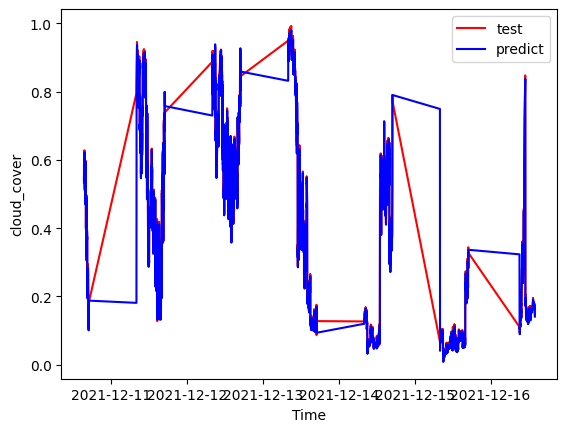

In [81]:
plt.plot(test['cloud_cover'], color = 'red', label = 'test')
plt.plot(test['LSTM_2'], color = 'blue', label = 'predict')
plt.xlabel('Time')
plt.ylabel('cloud_cover')
plt.legend()
plt.show()

---

## Add first layer: units = 100 and change epochs from 30 to 50

In [ ]:
regressor_3 = Sequential()
regressor_3.add(LSTM(units = 100, return_sequences = False, input_shape = (X_train.shape[1], 1)))
regressor_3.add(Dense(units = 1))
regressor_3.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
regressor_3.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
376/376 [==============================] - 8s 17ms/step - loss: 0.0123
Epoch 2/50
376/376 [==============================] - 6s 17ms/step - loss: 0.0020
Epoch 3/50
376/376 [==============================] - 6s 16ms/step - loss: 0.0017
Epoch 4/50
376/376 [==============================] - 6s 16ms/step - loss: 0.0015
Epoch 5/50
376/376 [==============================] - 6s 16ms/step - loss: 0.0013
Epoch 6/50
376/376 [==============================] - 6s 16ms/step - loss: 0.0012
Epoch 7/50
376/376 [==============================] - 6s 16ms/step - loss: 0.0011
Epoch 8/50
376/376 [==============================] - 6s 16ms/step - loss: 0.0011
Epoch 9/50
376/376 [==============================] - 6s 16ms/step - loss: 0.0011
Epoch 10/50
376/376 [==============================] - 6s 16ms/step - loss: 0.0010
Epoch 11/50
376/376 [==============================] - 6s 16ms/step - loss: 0.0010
Epoch 12/50
376/376 [==============================] - 7s 19ms/step - loss: 9.8988e-04
Epoch 13/

In [ ]:
predict_scaled_3 = regressor_3.predict(X_test)
predict_scaled_3

95/95 [==============================] - 1s 6ms/step


array([[0.5453596 ],
       [0.53058887],
       [0.59414107],
       ...,
       [0.16902316],
       [0.14744028],
       [0.14547437]], dtype=float32)

In [ ]:
predict_3 = sc.inverse_transform(predict_scaled_3)
predict_3

array([[0.5464962 ],
       [0.53176236],
       [0.5951557 ],
       ...,
       [0.1711006 ],
       [0.14957169],
       [0.1476107 ]], dtype=float32)

In [ ]:
test['LSTM_3'] = predict_3
test

,cloud_cover,LSTM,LSTM_1,LSTM_2,LSTM_3
DateTime,,,,,
2021-12-10 15:24:00,0.538,0.550252,0.547932,0.544854,0.546496
2021-12-10 15:25:00,0.588,0.532445,0.529431,0.531344,0.531762
2021-12-10 15:26:00,0.566,0.586850,0.588783,0.585641,0.595156
2021-12-10 15:27:00,0.562,0.559706,0.557712,0.565116,0.566978
2021-12-10 15:28:00,0.612,0.558966,0.559031,0.563885,0.563719
...,...,...,...,...,...
2021-12-16 13:58:00,0.168,0.168656,0.168967,0.182248,0.170053
2021-12-16 13:59:00,0.169,0.168764,0.169334,0.181958,0.170130
2021-12-16 14:00:00,0.147,0.169780,0.170340,0.182674,0.171101


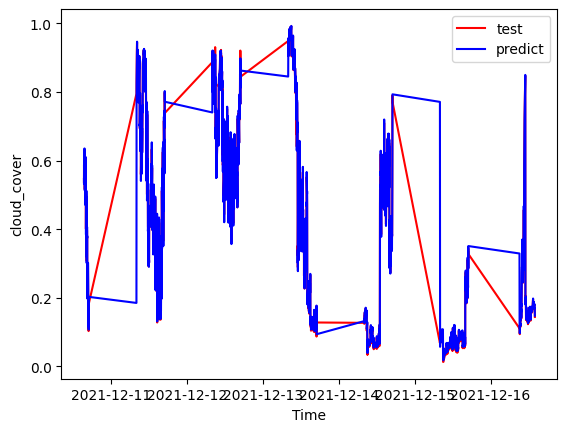

In [ ]:
plt.plot(test['cloud_cover'], color = 'red', label = 'test')
plt.plot(test['LSTM_3'], color = 'blue', label = 'predict')
plt.xlabel('Time')
plt.ylabel('cloud_cover')
plt.legend()
plt.show()

In [ ]:
test['LSTM_3'] = predict_3
test

,cloud_cover,LSTM,LSTM_1,LSTM_2,LSTM_3
DateTime,,,,,
2021-12-10 15:24:00,0.538,0.550252,0.547932,0.544854,0.546496
2021-12-10 15:25:00,0.588,0.532445,0.529431,0.531344,0.531762
2021-12-10 15:26:00,0.566,0.586850,0.588783,0.585641,0.595156
2021-12-10 15:27:00,0.562,0.559706,0.557712,0.565116,0.566978
2021-12-10 15:28:00,0.612,0.558966,0.559031,0.563885,0.563719
...,...,...,...,...,...
2021-12-16 13:58:00,0.168,0.168656,0.168967,0.182248,0.170053
2021-12-16 13:59:00,0.169,0.168764,0.169334,0.181958,0.170130
2021-12-16 14:00:00,0.147,0.169780,0.170340,0.182674,0.171101


In [ ]:
lstm_mse_error = mean_squared_error(test['cloud_cover'], test['LSTM_3'], squared=True)
lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM_3'], squared=False)
lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM_3'])
lstm_r2 = r2_score(test['cloud_cover'], test['LSTM_3'])
print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )

MSE Error: 0.0020680498815092495
RMSE Error: 0.04547581644686821
MAE: 0.020609069233053633
r2_score: 0.9749825335475739


---

## Add frist layer and second layer: units = 50

In [ ]:
# regressor_4 = Sequential()
# regressor_4.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1], 1)))
# regressor_4.add(Dense(units = 1))
# regressor_4.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
# regressor_4.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30
376/376 [==============================] - 9s 13ms/step - loss: 0.0102
Epoch 2/30
376/376 [==============================] - 5s 13ms/step - loss: 0.0027
Epoch 3/30
376/376 [==============================] - 5s 12ms/step - loss: 0.0021
Epoch 4/30
376/376 [==============================] - 5s 14ms/step - loss: 0.0018
Epoch 5/30
376/376 [==============================] - 5s 14ms/step - loss: 0.0015
Epoch 6/30
376/376 [==============================] - 5s 13ms/step - loss: 0.0014
Epoch 7/30
376/376 [==============================] - 4s 12ms/step - loss: 0.0012
Epoch 8/30
376/376 [==============================] - 5s 13ms/step - loss: 0.0011
Epoch 9/30
376/376 [==============================] - 4s 12ms/step - loss: 0.0011
Epoch 10/30
376/376 [==============================] - 5s 12ms/step - loss: 0.0010
Epoch 11/30
376/376 [==============================] - 5s 14ms/step - loss: 0.0010
Epoch 12/30
376/376 [==============================] - 5s 13ms/step - loss: 9.8499e-04
Epoch 13/

In [ ]:
# predict_scaled_4 = regressor_4.predict(X_test)
# predict_scaled_4

95/95 [==============================] - 1s 4ms/step


array([[0.5555098 ],
       [0.53772444],
       [0.5890771 ],
       ...,
       [0.17032892],
       [0.14933665],
       [0.14721385]], dtype=float32)

In [ ]:
# predict_4 = sc.inverse_transform(predict_scaled_4)

In [ ]:
# test['LSTM_4'] = predict_4
# test

,cloud_cover,LSTM,LSTM_1,LSTM_2,LSTM_3,LSTM_4
DateTime,,,,,,
2021-12-10 15:24:00,0.538,0.550252,0.547932,0.544854,0.546496,0.556621
2021-12-10 15:25:00,0.588,0.532445,0.529431,0.531344,0.531762,0.538880
2021-12-10 15:26:00,0.566,0.586850,0.588783,0.585641,0.595156,0.590104
2021-12-10 15:27:00,0.562,0.559706,0.557712,0.565116,0.566978,0.564197
2021-12-10 15:28:00,0.612,0.558966,0.559031,0.563885,0.563719,0.562387
...,...,...,...,...,...,...
2021-12-16 13:58:00,0.168,0.168656,0.168967,0.182248,0.170053,0.171468
2021-12-16 13:59:00,0.169,0.168764,0.169334,0.181958,0.170130,0.171479
2021-12-16 14:00:00,0.147,0.169780,0.170340,0.182674,0.171101,0.172403


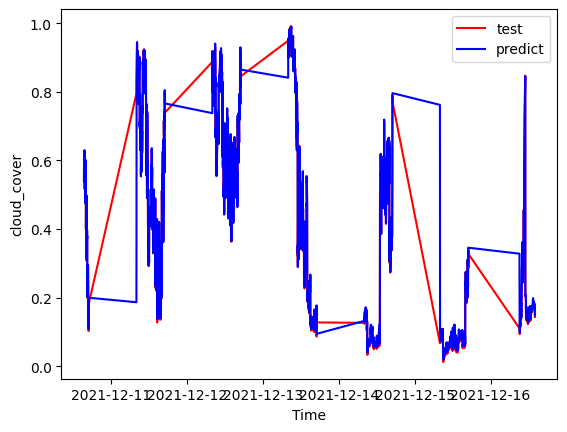

In [ ]:
# plt.plot(test['cloud_cover'], color = 'red', label = 'test')
# plt.plot(test['LSTM_4'], color = 'blue', label = 'predict')
# plt.xlabel('Time')
# plt.ylabel('cloud_cover')
# plt.legend()
# plt.show()

In [ ]:
# lstm_mse_error = mean_squared_error(test['cloud_cover'], test['LSTM_4'], squared=True)
# lstm_rmse_error = mean_squared_error(test['cloud_cover'], test['LSTM_4'], squared=False)
# lstm_mae_error = mean_absolute_error(test['cloud_cover'], test['LSTM_4'])
# lstm_r2 = r2_score(test['cloud_cover'], test['LSTM_4'])
# print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )

MSE Error: 0.0019961814127682827
RMSE Error: 0.04467864604896038
MAE: 0.020685414780127892
r2_score: 0.9758519356939102


---

In [ ]:
cloud_cover1 = pd.read_csv('../succeed-prophet/Bangkhuntean_CloudCover_2021-16Nov-16Dec.csv',skipinitialspace = True)
cloud_cover1['Date'] = cloud_cover1[['Year', 'Month', 'Day']].apply(lambda x: "{0}-{1}-{2}".format(str(x[0]).zfill(2), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1) 
cloud_cover1.drop(["Year", "Month", "Day", "Hour", "Minute", "Second"], axis=1, inplace=True)  
cloud_cover1 = cloud_cover1.rename(columns={"CloudCover":"cloud_cover"})
cloud_cover1 = cloud_cover1.groupby(['Date']).agg(cloud_cover=('cloud_cover','mean')).reset_index()    
cloud_cover1['Date'] = pd.to_datetime(cloud_cover1['Date'], format="%Y-%m-%d")
cloud_cover1.dropna(inplace=True)
cloud_cover1

,Date,cloud_cover
0,2021-11-16,0.769193
1,2021-11-17,0.364608
2,2021-11-18,0.878172
3,2021-11-19,0.529353
4,2021-11-20,0.449684
5,2021-11-21,0.443777
6,2021-11-22,0.496665
7,2021-11-23,0.954683
8,2021-11-24,0.665824
9,2021-11-25,0.369516


# Train/Test Model

In [ ]:
train1,test1 = train_test_split(cloud_cover1, train_size=0.8, shuffle=False)
print('Train Shape', train1.shape)
print('Test Shape', test1.shape)

Train Shape (24, 2)
Test Shape (6, 2)


In [ ]:
train1 = train1.set_index('Date')
test1 = test1.set_index('Date')

sc1 = MinMaxScaler(feature_range = (0, 1))
training_set_scaled1 = sc1.fit_transform(train1)

X_train1 = []
y_train1 = []
for i in range(5, 24):
    X_train1.append(training_set_scaled1[i-5:i, 0])
    y_train1.append(training_set_scaled1[i, 0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], 1))

In [ ]:
dataset_total1 = pd.concat((train1['cloud_cover'],test1['cloud_cover']), axis = 0)
inputs1 = dataset_total1[len(dataset_total1) - len(test1) - 5:].values
inputs1 = inputs1.reshape(-1,1)
inputs1 = sc1.transform(inputs1)
X_test1 = []
for i in range(5, 11):
    X_test1.append(inputs[i-5:i, 0])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], 1))

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
regressor_d = Sequential()
regressor_d.add(LSTM(units = 50, activation='relu', input_shape = (X_train1.shape[1], 1)))
regressor_d.add(Dense(units = 1))
regressor_d.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
regressor_d.fit(X_train1, y_train1, epochs = 30, batch_size = 32)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 0.3125
Epoch 2/30
1/1 [==============================] - 0s 8ms/step - loss: 0.3057
Epoch 3/30
1/1 [==============================] - 0s 9ms/step - loss: 0.2989
Epoch 4/30
1/1 [==============================] - 0s 8ms/step - loss: 0.2922
Epoch 5/30
1/1 [==============================] - 0s 8ms/step - loss: 0.2855
Epoch 6/30
1/1 [==============================] - 0s 7ms/step - loss: 0.2788
Epoch 7/30
1/1 [==============================] - 0s 7ms/step - loss: 0.2722
Epoch 8/30
1/1 [==============================] - 0s 7ms/step - loss: 0.2657
Epoch 9/30
1/1 [==============================] - 0s 7ms/step - loss: 0.2593
Epoch 10/30
1/1 [==============================] - 0s 7ms/step - loss: 0.2530
Epoch 11/30
1/1 [==============================] - 0s 8ms/step - loss: 0.2468
Epoch 12/30
1/1 [==============================] - 0s 8ms/step - loss: 0.2406
Epoch 13/30
1/1 [==============================] - 0s 10ms/step - loss: 0.

In [ ]:
predict_scaled_d = regressor_d.predict(X_test1)
predict_scaled_d

1/1 [==============================] - 0s 225ms/step


array([[0.3062846 ],
       [0.31638327],
       [0.32527584],
       [0.33432806],
       [0.34558386],
       [0.3572604 ]], dtype=float32)

In [ ]:
predict_d = sc1.inverse_transform(predict_scaled_d)
predict_d

array([[0.34656155],
       [0.35599682],
       [0.36430523],
       [0.37276277],
       [0.38327917],
       [0.39418867]], dtype=float32)

In [ ]:
test1['LSTM'] = predict_d
test1

,cloud_cover,LSTM
Date,,
2021-12-11,0.539296,0.346562
2021-12-12,0.671356,0.355997
2021-12-13,0.476423,0.364305
2021-12-14,0.260594,0.372763
2021-12-15,0.085025,0.383279
2021-12-16,0.228007,0.394189


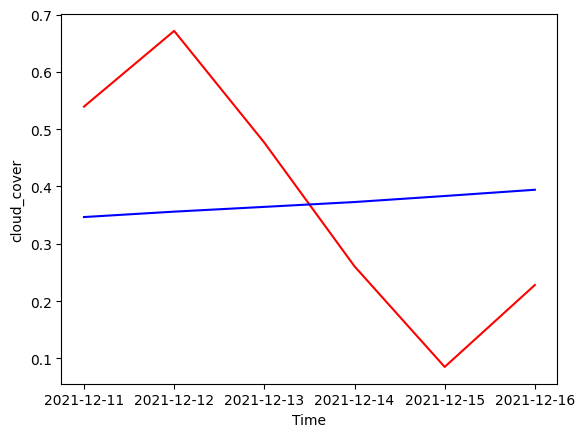

In [ ]:
plt.plot(test1['cloud_cover'], color = 'red', label = 'test')
plt.plot(test1['LSTM'], color = 'blue', label = 'predict')
plt.xlabel('Time')
plt.ylabel('cloud_cover')
plt.show()

In [ ]:
lstm_mse_error = mean_squared_error(test1['cloud_cover'], test1['LSTM'], squared=True)
lstm_rmse_error = mean_squared_error(test1['cloud_cover'], test1['LSTM'], squared=False)
lstm_mae_error = mean_absolute_error(test1['cloud_cover'], test1['LSTM'])
lstm_r2 = r2_score(test1['cloud_cover'], test1['LSTM'])
print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMAE: {lstm_mae_error}\nr2_score: {lstm_r2}' )


MSE Error: 0.046387037620043765
RMSE Error: 0.21537650201459713
MAE: 0.1994694150568058
r2_score: -0.1412780781639702
